# TCGA: Data load, filter, transform (preliminar)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn as sk
import statsmodels.api as sm
import sys
import os

from pathlib import Path

# Load data

In [3]:
def rnaseq_load(cancer_type):
    ''' Load RnaSeq dataFrame and remove first row '''
    data_path = Path('data')
    file_name = data_path / 'tcga' / f"{cancer_type}.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt"
    print(f"Loading file: '{file_name}'")
    df = pd.read_csv(file_name, sep="\t", index_col=0, low_memory=False)
    df.drop('gene_id', inplace=True) # Remove second row, we don't use it
    df = df.astype('float')  # Convert values to float
    df.index.name = None  # Remove index name
    return df

df_luad = rnaseq_load('LUAD')
df_lusc = rnaseq_load('LUSC')

Loading file: 'data/tcga/LUAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt'
Loading file: 'data/tcga/LUSC.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt'


### Are all the gene names the same in both dataframes?

In [4]:
all(df_luad.index == df_lusc.index)

True

### Join dataframes

In [5]:
df = pd.concat([df_lusc, df_luad], axis=1, sort=False)
df.shape, df_luad.shape, df_lusc.shape

((20531, 1128), (20531, 576), (20531, 552))

In [6]:
df = df_lusc.copy()

In [7]:
df.head()

,TCGA-18-3406-01A-01R-0980-07,TCGA-18-3407-01A-01R-0980-07,TCGA-18-3408-01A-01R-0980-07,TCGA-18-3409-01A-01R-0980-07,TCGA-18-3410-01A-01R-0980-07,TCGA-18-3411-01A-01R-0980-07,TCGA-18-3412-01A-01R-0980-07,TCGA-18-3414-01A-01R-0980-07,TCGA-18-3415-01A-01R-0980-07,TCGA-18-3416-01A-01R-0980-07,...,TCGA-NK-A5CX-01A-11R-A26W-07,TCGA-NK-A5D1-01A-11R-A26W-07,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-XC-AA0X-01A-32R-A405-07
?|100130426,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
?|100133144,75.3622,14.4148,8.4888,2.5897,16.6653,12.9418,47.5782,12.3168,55.1387,30.2103,...,40.3766,39.5911,20.8723,30.2240,4.2895,19.9503,30.0872,53.6593,72.5666,44.7501
?|100134869,25.4252,6.9933,3.3754,7.1538,19.5722,14.4142,20.8881,25.7116,39.0809,7.7269,...,17.3322,21.7407,15.7901,4.2022,3.6632,47.1026,15.2957,33.3907,42.1832,23.6304
?|10357,279.9764,198.2540,254.5929,164.3744,200.8033,277.6667,394.3623,205.8704,162.0405,130.9450,...,142.3695,234.1647,133.6915,131.5628,153.5980,176.7177,188.7215,260.3332,160.1624,76.6488
?|10431,1510.2362,968.6013,1474.1213,944.6154,1156.0568,1119.5816,861.5023,1030.4597,1931.2139,1426.5530,...,935.5667,777.4533,2257.2693,607.6503,1103.4483,1188.3278,1248.0303,789.3606,460.8626,805.9507


In [8]:
df.tail()

,TCGA-18-3406-01A-01R-0980-07,TCGA-18-3407-01A-01R-0980-07,TCGA-18-3408-01A-01R-0980-07,TCGA-18-3409-01A-01R-0980-07,TCGA-18-3410-01A-01R-0980-07,TCGA-18-3411-01A-01R-0980-07,TCGA-18-3412-01A-01R-0980-07,TCGA-18-3414-01A-01R-0980-07,TCGA-18-3415-01A-01R-0980-07,TCGA-18-3416-01A-01R-0980-07,...,TCGA-NK-A5CX-01A-11R-A26W-07,TCGA-NK-A5D1-01A-11R-A26W-07,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-XC-AA0X-01A-32R-A405-07
ZYX|7791,1914.9606,4221.6936,526.1753,4388.2051,3029.7749,2832.9478,3002.3474,4465.2021,2259.5376,2101.6133,...,5169.3361,2652.4533,1754.7408,7236.6120,8943.3986,2681.7053,6094.3376,2560.9887,1185.0373,5303.4060
ZZEF1|23140,265.3543,702.6641,589.6485,807.1795,735.7800,321.4322,466.7449,391.7297,349.1329,972.9795,...,865.6315,919.3925,768.0152,762.8415,644.6723,1069.5364,663.9353,730.2526,833.3333,1510.6355
ZZZ3|26009,738.5827,960.9895,757.5263,1008.7179,884.2752,966.7102,607.5900,818.1650,781.5029,919.9789,...,589.8032,876.1682,432.3641,589.6175,827.0892,783.1126,778.6532,761.9559,1383.1203,649.8760
psiTPTE22|387590,7.0866,11.4177,5.9321,48.2051,5.5144,9.2527,607.5900,590.3637,6.9364,3.9053,...,5.8687,157.1262,3.1606,463.3880,13.4203,5.3808,2.1011,12.3589,1.0650,460.3941
tAKR|389932,0.0000,0.4757,18.3894,0.0000,7.8777,2.0115,1.1737,0.0000,3.4682,115.4855,...,0.0000,0.0000,26.5487,0.0000,0.0000,1.2417,0.0000,0.0000,0.0000,0.0000


### Tumor types

In [9]:
def tumor_type(c):
    if c in df_luad.columns:
        return 'LUAD'
    if c in df_lusc.columns:
        return 'LUSC'
    return 'UNKNOWN'
    
tumor_types = np.array([tumor_type(c) for c in df.columns])

### Tumors vs normals

In [10]:
def is_tumor(bar_code):
    ''' Is the barcode tumor? '''
    tissue_type = bar_code.split('-')[3]
    return tissue_type[0] == '0' # First character '0' indicates 

In [11]:
tumors = np.array([is_tumor(c) for c in df.columns])
normals = ~tumors
tumors.sum(), normals.sum()

(501, 51)

In [12]:
df_normals = df.iloc[:, normals].copy()
df_normals.shape, df.shape

((20531, 51), (20531, 552))

In [13]:
df_normals.head()

,TCGA-22-4593-11A-01R-1820-07,TCGA-22-4609-11A-01R-2125-07,TCGA-22-5471-11A-01R-1635-07,TCGA-22-5472-11A-11R-1635-07,TCGA-22-5478-11A-11R-1635-07,TCGA-22-5481-11A-01R-1949-07,TCGA-22-5482-11A-01R-1635-07,TCGA-22-5483-11A-11R-1820-07,TCGA-22-5489-11A-01R-1635-07,TCGA-22-5491-11A-01R-1858-07,...,TCGA-77-7142-11A-01R-2045-07,TCGA-77-7335-11A-01R-2045-07,TCGA-77-7337-11A-01R-2045-07,TCGA-77-7338-11A-01R-2045-07,TCGA-77-8007-11A-01R-2187-07,TCGA-77-8008-11A-01R-2187-07,TCGA-85-7710-11A-01R-2125-07,TCGA-90-6837-11A-01R-1949-07,TCGA-90-7767-11A-01R-2125-07,TCGA-92-7340-11A-01R-2045-07
?|100130426,0.0000,0.0000,0.4281,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
?|100133144,2.3989,24.6089,2.1404,5.6509,8.4688,8.3328,3.9289,5.5387,5.4138,5.0359,...,13.9507,2.1008,5.2750,5.6425,11.1861,11.7308,29.6604,2.8280,17.9258,13.5526
?|100134869,7.1966,15.8939,8.9897,5.3689,20.3553,8.8687,6.7310,7.2306,13.5450,2.8327,...,7.9200,8.1032,5.1191,3.4218,18.1100,10.4841,22.0685,0.4057,10.9346,3.7880
?|10357,145.7135,91.6306,112.6199,133.0602,104.2446,107.8928,114.7995,103.1365,132.0644,108.5392,...,91.0284,163.5234,98.9693,83.5086,85.0625,65.4576,112.3263,124.2008,76.9899,75.6230
?|10431,825.9871,491.2709,525.6849,531.0006,525.6974,625.2067,485.0254,644.0543,553.1147,607.5949,...,497.4407,909.9640,504.9805,677.9341,1150.0536,763.5942,505.3808,458.8815,602.0229,495.4032


# Filter

### Remove invalid gene names

In [14]:
def is_valid_gene_name(genes):
    " Invalid gene names start with '?' "
    return [g[0] != '?' for g in genes]

keep_valid_genes = np.array(is_valid_gene_name(df.index.values))
keep_valid_genes.sum(), keep_valid_genes.shape, df.shape

(20502, (20531,), (20531, 552))

In [15]:
df_normals.iloc[keep_valid_genes,:].shape

(20502, 51)

### Filter out duplicated gene names

In [16]:
gene_names = np.array([g.split('|')[0] for g in df.index.values])
un, uc = np.unique(gene_names, return_counts=True)
gene_dups = set(un[uc > 1])
keep_gene_name_uniq = np.array([g not in gene_dups for g in gene_names])
keep_gene_name_uniq.shape

(20531,)

In [17]:
df_normals.iloc[keep_valid_genes & keep_gene_name_uniq,:].shape

(20500, 51)

In [18]:
df_normals.iloc[keep_valid_genes & keep_gene_name_uniq,:].head(10)

,TCGA-22-4593-11A-01R-1820-07,TCGA-22-4609-11A-01R-2125-07,TCGA-22-5471-11A-01R-1635-07,TCGA-22-5472-11A-11R-1635-07,TCGA-22-5478-11A-11R-1635-07,TCGA-22-5481-11A-01R-1949-07,TCGA-22-5482-11A-01R-1635-07,TCGA-22-5483-11A-11R-1820-07,TCGA-22-5489-11A-01R-1635-07,TCGA-22-5491-11A-01R-1858-07,...,TCGA-77-7142-11A-01R-2045-07,TCGA-77-7335-11A-01R-2045-07,TCGA-77-7337-11A-01R-2045-07,TCGA-77-7338-11A-01R-2045-07,TCGA-77-8007-11A-01R-2187-07,TCGA-77-8008-11A-01R-2187-07,TCGA-85-7710-11A-01R-2125-07,TCGA-90-6837-11A-01R-1949-07,TCGA-90-7767-11A-01R-2125-07,TCGA-92-7340-11A-01R-2045-07
A1BG|1,49.4892,68.5126,42.2731,31.6294,34.7839,128.8852,63.3046,40.7023,103.8339,87.6223,...,48.8692,60.9304,47.1156,49.1474,173.8442,102.7918,161.0371,41.0612,76.3264,43.7910
A1CF|29974,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.6002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2990
A2BP1|54715,1.0373,0.0000,0.0000,0.2563,0.0000,0.0000,1.0152,0.3990,0.6019,0.3421,...,3.2573,0.6002,0.0000,0.0000,0.0000,0.0000,0.3722,0.8819,2.6972,0.5980
A2LD1|87769,105.2180,66.7109,55.1627,62.5079,59.0291,58.6834,71.1751,74.5092,69.0069,78.9531,...,40.4141,77.3349,52.6895,89.3060,132.5974,76.3428,79.1900,55.2657,61.2515,58.7099
A2ML1|144568,0.0000,3.8408,0.0000,2.3065,0.5490,0.9924,0.5076,1.1971,1.5047,2.0527,...,0.0000,0.0000,0.0000,1.5107,0.0000,0.3316,1.8608,1.1759,0.5394,0.8969
A2M|2,138242.4240,113727.5698,88731.1344,192207.5233,90213.4661,68201.3761,167652.7259,168079.7686,118613.2290,99867.4718,...,115564.7743,92538.9196,120604.4781,128544.8060,111722.0543,132908.2692,45654.9585,217293.1285,115944.0432,103940.0314
A4GALT|53947,386.9302,384.7765,540.2397,391.5873,177.0626,492.2263,351.0152,544.6927,601.8658,463.2227,...,231.2704,267.1068,343.0056,402.6060,428.0100,1296.7507,408.9938,555.8904,501.9555,401.8238
A4GNT|51146,2.0747,0.6983,11.5582,5.1255,5.2158,1.9848,3.0457,0.0000,2.7084,0.6842,...,6.0493,5.4022,4.7640,0.7554,1.4291,1.3263,7.0709,4.1155,5.1247,2.0928
AAA1|404744,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
AAAS|8086,558.8704,453.5615,615.5822,499.9914,464.2059,584.8495,496.7005,571.8276,604.8751,556.9620,...,520.2420,506.6026,537.8952,484.5624,583.0654,615.3846,651.2640,551.7748,584.4909,421.5562


### Filter out genes with low number of normal values
Note: Another reason to do this, is that many normality test would fail (see below)

In [19]:
normals_min = 31
keep_normals_min = ((df_normals > 0).sum(axis=1) >= normals_min).values
keep_normals_min.sum(), (~keep_normals_min).sum(), keep_normals_min.shape, df_normals.shape, df.shape

(17720, 2811, (20531,), (20531, 51), (20531, 552))

In [20]:
df_normals.iloc[keep_valid_genes & keep_gene_name_uniq & keep_normals_min,:].shape

(17701, 51)

In [21]:
df_normals.iloc[keep_valid_genes & keep_gene_name_uniq & keep_normals_min,:].head(10)

,TCGA-22-4593-11A-01R-1820-07,TCGA-22-4609-11A-01R-2125-07,TCGA-22-5471-11A-01R-1635-07,TCGA-22-5472-11A-11R-1635-07,TCGA-22-5478-11A-11R-1635-07,TCGA-22-5481-11A-01R-1949-07,TCGA-22-5482-11A-01R-1635-07,TCGA-22-5483-11A-11R-1820-07,TCGA-22-5489-11A-01R-1635-07,TCGA-22-5491-11A-01R-1858-07,...,TCGA-77-7142-11A-01R-2045-07,TCGA-77-7335-11A-01R-2045-07,TCGA-77-7337-11A-01R-2045-07,TCGA-77-7338-11A-01R-2045-07,TCGA-77-8007-11A-01R-2187-07,TCGA-77-8008-11A-01R-2187-07,TCGA-85-7710-11A-01R-2125-07,TCGA-90-6837-11A-01R-1949-07,TCGA-90-7767-11A-01R-2125-07,TCGA-92-7340-11A-01R-2045-07
A1BG|1,49.4892,68.5126,42.2731,31.6294,34.7839,128.8852,63.3046,40.7023,103.8339,87.6223,...,48.8692,60.9304,47.1156,49.1474,173.8442,102.7918,161.0371,41.0612,76.3264,43.7910
A2BP1|54715,1.0373,0.0000,0.0000,0.2563,0.0000,0.0000,1.0152,0.3990,0.6019,0.3421,...,3.2573,0.6002,0.0000,0.0000,0.0000,0.0000,0.3722,0.8819,2.6972,0.5980
A2LD1|87769,105.2180,66.7109,55.1627,62.5079,59.0291,58.6834,71.1751,74.5092,69.0069,78.9531,...,40.4141,77.3349,52.6895,89.3060,132.5974,76.3428,79.1900,55.2657,61.2515,58.7099
A2ML1|144568,0.0000,3.8408,0.0000,2.3065,0.5490,0.9924,0.5076,1.1971,1.5047,2.0527,...,0.0000,0.0000,0.0000,1.5107,0.0000,0.3316,1.8608,1.1759,0.5394,0.8969
A2M|2,138242.4240,113727.5698,88731.1344,192207.5233,90213.4661,68201.3761,167652.7259,168079.7686,118613.2290,99867.4718,...,115564.7743,92538.9196,120604.4781,128544.8060,111722.0543,132908.2692,45654.9585,217293.1285,115944.0432,103940.0314
A4GALT|53947,386.9302,384.7765,540.2397,391.5873,177.0626,492.2263,351.0152,544.6927,601.8658,463.2227,...,231.2704,267.1068,343.0056,402.6060,428.0100,1296.7507,408.9938,555.8904,501.9555,401.8238
A4GNT|51146,2.0747,0.6983,11.5582,5.1255,5.2158,1.9848,3.0457,0.0000,2.7084,0.6842,...,6.0493,5.4022,4.7640,0.7554,1.4291,1.3263,7.0709,4.1155,5.1247,2.0928
AAAS|8086,558.8704,453.5615,615.5822,499.9914,464.2059,584.8495,496.7005,571.8276,604.8751,556.9620,...,520.2420,506.6026,537.8952,484.5624,583.0654,615.3846,651.2640,551.7748,584.4909,421.5562
AACSL|729522,1.8154,2.0950,1.2842,1.5376,0.8235,0.9924,3.5533,0.0000,3.0093,4.4475,...,1.3960,1.8007,4.3309,0.3777,0.3573,0.0000,0.3722,2.3517,5.6642,1.1959
AACS|65985,996.1119,775.8380,723.0308,707.8299,563.0315,669.8644,513.4518,887.0710,708.0951,707.8344,...,482.0847,653.0612,480.2945,606.5527,548.7674,652.1883,529.5706,606.1586,494.6730,376.1118


### Normality test / log-normality test

In [22]:
def normality_test(x, use_logp1, count_min=normals_min):
    try:
        # We need at least 'normals_min' values to calculate normality test
        if (x > 0).sum() < count_min:
            return np.nan
        x = np.log(x + 1) if use_logp1 else x
        norm_test = sm.stats.diagnostic.kstest_normal(x)
        return norm_test[1]  # This is the p-value
    except ValueError:
        return np.nan  # Test failed

def normality(df, use_logp1):
    """ Do a normality test, or a log-normality test if '''use_log' is set """
    pvals = [normality_test(df.iloc[i,], use_logp1) for i in range(df.shape[0])]
    pvals = np.array(pvals)
    print(f"Failed tests: {np.isnan(pvals).sum()}")
    pvals = np.nan_to_num(pvals, nan=0) # Test failed? Assume not normal
    return pvals

In [23]:
pval_threshold = 0.05
pvals_norm = normality(df_normals, use_logp1=False)
pvals_lognorm = normality(df_normals, use_logp1=True)

Failed tests: 2811
Failed tests: 2811


In [24]:
(pvals_norm > pval_threshold).sum(), (pvals_norm <= pval_threshold).sum(), (pvals_lognorm > pval_threshold).sum(), (pvals_lognorm <= pval_threshold).sum(), pvals_norm.shape , pvals_lognorm.shape

(8315, 12216, 14158, 6373, (20531,), (20531,))

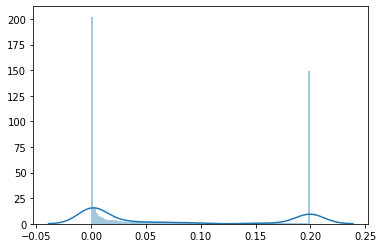

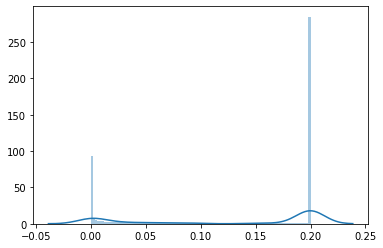

In [25]:
sb.distplot(pvals_norm, bins=100)
plt.figure()
sb.distplot(pvals_lognorm, bins=100)

In [26]:
(pvals_norm > pval_threshold).sum(), (pvals_lognorm > pval_threshold).sum()

(8315, 14158)

### Filter non-normal genes

In [27]:
keep_lognorm = (pvals_lognorm > pval_threshold)
keep_lognorm.sum(), keep_lognorm.shape

(14158, (20531,))

### Remove genes with too much missing data

In [28]:
expr_min = 0.9
num_samples = df.shape[1]
keep_exprmin = ((df > 0).sum(axis=1) / num_samples >= expr_min).values
keep_exprmin.sum(), (~keep_exprmin).sum(), keep_exprmin.shape

(16232, 4299, (20531,))

In [29]:
df.iloc[keep_valid_genes & keep_gene_name_uniq & keep_normals_min& keep_lognorm & keep_exprmin, tumors].head(10)

,TCGA-18-3406-01A-01R-0980-07,TCGA-18-3407-01A-01R-0980-07,TCGA-18-3408-01A-01R-0980-07,TCGA-18-3409-01A-01R-0980-07,TCGA-18-3410-01A-01R-0980-07,TCGA-18-3411-01A-01R-0980-07,TCGA-18-3412-01A-01R-0980-07,TCGA-18-3414-01A-01R-0980-07,TCGA-18-3415-01A-01R-0980-07,TCGA-18-3416-01A-01R-0980-07,...,TCGA-NK-A5CX-01A-11R-A26W-07,TCGA-NK-A5D1-01A-11R-A26W-07,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-XC-AA0X-01A-32R-A405-07
A1BG|1,741.6929,46.7127,1.1864,162.6462,273.8811,162.0396,26.1737,40.2769,104.0462,55.9910,...,81.6286,113.9019,240.0632,332.0984,104.9668,133.1664,148.8055,52.7243,14.9281,52.4964
A2LD1|87769,170.2362,118.4063,148.3316,68.7795,172.2190,180.3922,130.3717,99.7785,167.9595,59.3718,...,56.5644,11.6706,162.1113,93.7104,91.2084,75.6954,86.9041,81.4992,43.5304,49.1035
A4GALT|53947,181.8898,1318.7441,190.4197,266.1538,1039.0726,3294.3780,2747.6526,1443.2343,887.8613,470.3106,...,1291.1114,211.4486,1316.0556,318.0328,672.5070,382.8642,1188.7803,5458.3557,26.8903,2560.8769
AACS|65985,1741.7323,1389.6289,424.1436,604.1026,1897.3512,1056.4216,1707.7465,812.9961,1020.2312,592.4909,...,1429.5146,865.6542,1249.6839,1469.9454,701.3358,707.7815,731.5895,1027.9420,1427.0501,1401.0179
AADAC|13,84.2520,51.8554,218.8937,103.5897,5.5144,28.5628,735.5243,131.0689,81.5029,34.0320,...,16.6279,75.9346,152.9709,12.5683,6.4616,30.6291,65.5531,475.0134,1.8637,176.9542
AADAT|51166,22.0472,58.0400,361.2635,142.5641,70.8996,58.7348,52.4257,93.7788,35.8382,1.1158,...,27.3872,382.0093,3.1606,68.8525,109.3507,125.8278,61.3510,49.4358,456.0703,70.9905
AAMP|14,2233.0709,2329.6860,1526.9168,2622.5641,2660.3093,2860.3037,2759.7809,2612.5162,2041.6185,972.4216,...,2266.7808,3564.8364,2813.5272,3359.5628,2624.9146,2686.6722,3304.9690,3845.7818,1313.0990,3114.7070
AARSD1|80755,376.3780,390.1047,444.3126,548.7179,350.9529,524.5902,487.4804,266.9374,320.8092,142.8227,...,360.4353,735.3972,1431.7320,1167.7596,678.9686,791.3907,614.3502,537.8829,593.7167,499.0213
AARS|16,3607.0866,1929.1151,3803.6482,4046.6667,2554.3539,4684.3005,4302.8169,3459.8486,2505.2023,3458.4287,...,4054.7744,2931.6589,1955.7522,1488.5246,3164.7095,10120.8609,2855.3419,3266.5234,5865.0160,2963.3303
AASDHPPT|60496,1577.9528,960.5138,1366.7507,1233.8462,1145.0280,1220.5572,628.3255,1547.6906,1480.3468,687.8920,...,721.3596,675.2336,691.5297,561.2022,941.9074,1137.0033,795.0415,675.9807,934.5048,528.7746


### Apply all filters

In [30]:
df.shape, keep_valid_genes.shape, keep_normals_min.shape, keep_exprmin.shape, keep_lognorm.shape

((20531, 552), (20531,), (20531,), (20531,), (20531,))

In [31]:
df_filtered = df.iloc[keep_valid_genes & keep_gene_name_uniq & keep_normals_min& keep_lognorm & keep_exprmin, :].copy()
df_filtered.shape

(13225, 552)

In [32]:
df_filtered.head(10)

,TCGA-18-3406-01A-01R-0980-07,TCGA-18-3407-01A-01R-0980-07,TCGA-18-3408-01A-01R-0980-07,TCGA-18-3409-01A-01R-0980-07,TCGA-18-3410-01A-01R-0980-07,TCGA-18-3411-01A-01R-0980-07,TCGA-18-3412-01A-01R-0980-07,TCGA-18-3414-01A-01R-0980-07,TCGA-18-3415-01A-01R-0980-07,TCGA-18-3416-01A-01R-0980-07,...,TCGA-NK-A5CX-01A-11R-A26W-07,TCGA-NK-A5D1-01A-11R-A26W-07,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-XC-AA0X-01A-32R-A405-07
A1BG|1,741.6929,46.7127,1.1864,162.6462,273.8811,162.0396,26.1737,40.2769,104.0462,55.9910,...,81.6286,113.9019,240.0632,332.0984,104.9668,133.1664,148.8055,52.7243,14.9281,52.4964
A2LD1|87769,170.2362,118.4063,148.3316,68.7795,172.2190,180.3922,130.3717,99.7785,167.9595,59.3718,...,56.5644,11.6706,162.1113,93.7104,91.2084,75.6954,86.9041,81.4992,43.5304,49.1035
A4GALT|53947,181.8898,1318.7441,190.4197,266.1538,1039.0726,3294.3780,2747.6526,1443.2343,887.8613,470.3106,...,1291.1114,211.4486,1316.0556,318.0328,672.5070,382.8642,1188.7803,5458.3557,26.8903,2560.8769
AACS|65985,1741.7323,1389.6289,424.1436,604.1026,1897.3512,1056.4216,1707.7465,812.9961,1020.2312,592.4909,...,1429.5146,865.6542,1249.6839,1469.9454,701.3358,707.7815,731.5895,1027.9420,1427.0501,1401.0179
AADAC|13,84.2520,51.8554,218.8937,103.5897,5.5144,28.5628,735.5243,131.0689,81.5029,34.0320,...,16.6279,75.9346,152.9709,12.5683,6.4616,30.6291,65.5531,475.0134,1.8637,176.9542
AADAT|51166,22.0472,58.0400,361.2635,142.5641,70.8996,58.7348,52.4257,93.7788,35.8382,1.1158,...,27.3872,382.0093,3.1606,68.8525,109.3507,125.8278,61.3510,49.4358,456.0703,70.9905
AAMP|14,2233.0709,2329.6860,1526.9168,2622.5641,2660.3093,2860.3037,2759.7809,2612.5162,2041.6185,972.4216,...,2266.7808,3564.8364,2813.5272,3359.5628,2624.9146,2686.6722,3304.9690,3845.7818,1313.0990,3114.7070
AARSD1|80755,376.3780,390.1047,444.3126,548.7179,350.9529,524.5902,487.4804,266.9374,320.8092,142.8227,...,360.4353,735.3972,1431.7320,1167.7596,678.9686,791.3907,614.3502,537.8829,593.7167,499.0213
AARS|16,3607.0866,1929.1151,3803.6482,4046.6667,2554.3539,4684.3005,4302.8169,3459.8486,2505.2023,3458.4287,...,4054.7744,2931.6589,1955.7522,1488.5246,3164.7095,10120.8609,2855.3419,3266.5234,5865.0160,2963.3303
AASDHPPT|60496,1577.9528,960.5138,1366.7507,1233.8462,1145.0280,1220.5572,628.3255,1547.6906,1480.3468,687.8920,...,721.3596,675.2336,691.5297,561.2022,941.9074,1137.0033,795.0415,675.9807,934.5048,528.7746


# Convert to log+1 and normalize

In [33]:
df_log = np.log(df_filtered + 1)

### We normalize respect to the "normal" samples (not all the samples)

In [34]:
mean_normals = df_log.iloc[:, normals].mean(axis=1)
std_normals = df_log.iloc[:, normals].std(axis=1)
mean_all = df_log.mean(axis=1)
std_all = df_log.std(axis=1)
pd.DataFrame({'mean_normals': mean_normals, 'mean_all': mean_all, 'std_normals': std_normals, 'std_all': std_all})

,mean_normals,mean_all,std_normals,std_all
A1BG|1,4.359672,4.414782,0.488644,0.822561
A2LD1|87769,4.209382,4.372103,0.233608,0.460317
A4GALT|53947,6.139677,6.790657,0.407137,0.934834
AACS|65985,6.357457,6.834604,0.197908,0.467173
AADAC|13,5.130525,4.256603,0.899260,1.689289
...,...,...,...,...
ZYG11A|440590,0.530651,3.054641,0.431797,1.577846
ZYG11B|79699,6.872521,6.510439,0.231407,0.304842
ZYX|7791,8.942970,8.355565,0.235872,0.506487
ZZZ3|26009,6.292056,6.587615,0.196424,0.321770


In [35]:
df_z = df_log.sub(mean_normals, axis=0).div(std_normals, axis=0)
df_z.shape

(13225, 552)

In [36]:
df_z.head(10)

,TCGA-18-3406-01A-01R-0980-07,TCGA-18-3407-01A-01R-0980-07,TCGA-18-3408-01A-01R-0980-07,TCGA-18-3409-01A-01R-0980-07,TCGA-18-3410-01A-01R-0980-07,TCGA-18-3411-01A-01R-0980-07,TCGA-18-3412-01A-01R-0980-07,TCGA-18-3414-01A-01R-0980-07,TCGA-18-3415-01A-01R-0980-07,TCGA-18-3416-01A-01R-0980-07,...,TCGA-NK-A5CX-01A-11R-A26W-07,TCGA-NK-A5D1-01A-11R-A26W-07,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-XC-AA0X-01A-32R-A405-07
A1BG|1,4.605832,-1.011932,-7.321112,1.510375,2.571745,1.502775,-2.163994,-1.308456,0.603156,-0.648281,...,0.111910,0.786682,2.303084,2.964872,0.621013,1.103890,1.329529,-0.769080,-3.257152,-0.777780
A2LD1|87769,3.996706,2.453471,3.410791,0.153928,4.045989,4.243349,2.862271,1.727439,3.939410,-0.465992,...,-0.669828,-7.149146,3.788618,1.461604,1.346999,0.558458,1.142362,0.870720,-1.768816,-1.264044
A4GALT|53947,-2.286192,2.567973,-2.174228,-1.355446,1.983041,4.815578,4.370003,2.789376,1.597164,0.038907,...,2.515999,-1.918217,2.562964,-0.919550,0.915716,-0.465170,2.313343,6.055480,-6.905289,4.197160
AACS|65985,5.587209,4.446789,-1.541270,0.242241,6.019387,3.062698,5.487697,1.740703,2.886735,0.144336,...,4.589674,2.057439,3.910855,4.730503,0.995185,1.041346,1.208284,2.924743,4.580962,4.488002
AADAC|13,-0.761641,-1.293246,0.292039,-0.534306,-3.621320,-1.939381,1.636252,-0.274894,-0.798091,-1.750620,...,-2.514335,-0.875797,-0.104265,-2.805404,-3.470358,-1.864252,-1.036991,1.150858,-4.535294,0.056714
AADAT|51166,-5.855143,-2.306242,4.538088,1.046083,-1.562804,-2.262103,-2.683226,-0.520492,-4.085765,-14.864852,...,-5.068928,4.748182,-12.313630,-1.671779,0.053408,0.578447,-2.100385,-2.900500,5.415118,-1.558037
AAMP|14,1.620402,1.917441,-1.045127,2.747935,2.848156,3.356531,3.105611,2.721013,0.991816,-4.208255,...,1.725476,4.900907,3.240885,4.484926,2.754218,2.917314,4.370011,5.432990,-2.102821,3.954147
AARSD1|80755,0.725525,0.986634,1.935251,3.474576,0.215776,3.146557,2.611430,-1.777501,-0.438593,-6.324481,...,0.410070,5.611244,10.475377,8.987127,5.028609,6.146827,4.298845,3.329091,4.049587,2.782087
AARS|16,1.984786,-1.287486,2.262250,2.586115,0.180287,3.351302,2.907076,1.766858,0.078697,1.764712,...,2.596582,0.900643,-1.215793,-2.642861,1.300618,7.380287,0.762723,1.466194,4.526863,0.956829
AASDHPPT|60496,5.258397,2.301293,4.402316,3.792894,3.347879,3.728387,-0.225679,5.143024,4.877973,0.313482,...,0.596302,0.202915,0.344881,-0.898093,2.184795,3.305986,1.175361,0.209498,2.137805,-1.252283


### Rename genes

In [37]:
df_z.index = [g.split('|')[0] for g in df_z.index]

In [38]:
df_z.iloc[:, tumors].head(10)

,TCGA-18-3406-01A-01R-0980-07,TCGA-18-3407-01A-01R-0980-07,TCGA-18-3408-01A-01R-0980-07,TCGA-18-3409-01A-01R-0980-07,TCGA-18-3410-01A-01R-0980-07,TCGA-18-3411-01A-01R-0980-07,TCGA-18-3412-01A-01R-0980-07,TCGA-18-3414-01A-01R-0980-07,TCGA-18-3415-01A-01R-0980-07,TCGA-18-3416-01A-01R-0980-07,...,TCGA-NK-A5CX-01A-11R-A26W-07,TCGA-NK-A5D1-01A-11R-A26W-07,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-XC-AA0X-01A-32R-A405-07
A1BG,4.605832,-1.011932,-7.321112,1.510375,2.571745,1.502775,-2.163994,-1.308456,0.603156,-0.648281,...,0.111910,0.786682,2.303084,2.964872,0.621013,1.103890,1.329529,-0.769080,-3.257152,-0.777780
A2LD1,3.996706,2.453471,3.410791,0.153928,4.045989,4.243349,2.862271,1.727439,3.939410,-0.465992,...,-0.669828,-7.149146,3.788618,1.461604,1.346999,0.558458,1.142362,0.870720,-1.768816,-1.264044
A4GALT,-2.286192,2.567973,-2.174228,-1.355446,1.983041,4.815578,4.370003,2.789376,1.597164,0.038907,...,2.515999,-1.918217,2.562964,-0.919550,0.915716,-0.465170,2.313343,6.055480,-6.905289,4.197160
AACS,5.587209,4.446789,-1.541270,0.242241,6.019387,3.062698,5.487697,1.740703,2.886735,0.144336,...,4.589674,2.057439,3.910855,4.730503,0.995185,1.041346,1.208284,2.924743,4.580962,4.488002
AADAC,-0.761641,-1.293246,0.292039,-0.534306,-3.621320,-1.939381,1.636252,-0.274894,-0.798091,-1.750620,...,-2.514335,-0.875797,-0.104265,-2.805404,-3.470358,-1.864252,-1.036991,1.150858,-4.535294,0.056714
AADAT,-5.855143,-2.306242,4.538088,1.046083,-1.562804,-2.262103,-2.683226,-0.520492,-4.085765,-14.864852,...,-5.068928,4.748182,-12.313630,-1.671779,0.053408,0.578447,-2.100385,-2.900500,5.415118,-1.558037
AAMP,1.620402,1.917441,-1.045127,2.747935,2.848156,3.356531,3.105611,2.721013,0.991816,-4.208255,...,1.725476,4.900907,3.240885,4.484926,2.754218,2.917314,4.370011,5.432990,-2.102821,3.954147
AARSD1,0.725525,0.986634,1.935251,3.474576,0.215776,3.146557,2.611430,-1.777501,-0.438593,-6.324481,...,0.410070,5.611244,10.475377,8.987127,5.028609,6.146827,4.298845,3.329091,4.049587,2.782087
AARS,1.984786,-1.287486,2.262250,2.586115,0.180287,3.351302,2.907076,1.766858,0.078697,1.764712,...,2.596582,0.900643,-1.215793,-2.642861,1.300618,7.380287,0.762723,1.466194,4.526863,0.956829
AASDHPPT,5.258397,2.301293,4.402316,3.792894,3.347879,3.728387,-0.225679,5.143024,4.877973,0.313482,...,0.596302,0.202915,0.344881,-0.898093,2.184795,3.305986,1.175361,0.209498,2.137805,-1.252283


In [39]:
df_zt = df_z.iloc[:, tumors]
pd.DataFrame({'mean': df_zt.mean(axis=1), 'std': df_zt.std(axis=1)})

,mean,std
A1BG,0.124263,1.738186
A2LD1,0.767465,2.030824
A4GALT,1.761687,2.328647
AACS,2.656383,2.321066
AADAC,-1.070752,1.919033
...,...,...
ZYG11A,6.440342,3.282499
ZYG11B,-1.723976,1.239857
ZYX,-2.743867,2.069835
ZZZ3,1.657877,1.613311
